## Using Shallom embeddings for Fr-En Dbpedia

In [82]:
import scipy as sp
import numpy as np
import matplotlib.pylab as pl
from mpl_toolkits.mplot3d import Axes3D  # noqa
import ot
import pandas as pd
import json
from tqdm import tqdm
import time

In [2]:
EnFr_shallom_embs_v1 = pd.read_csv('Shallom_EnFr_15K_V1/Shallom_entity_embeddings.csv')

Fr_shallom_embs_v1 = EnFr_shallom_embs_v1[EnFr_shallom_embs_v1['Unnamed: 0'].apply(lambda x: 'fr.dbpedia.org' in x)]

En_shallom_embs_v1 = EnFr_shallom_embs_v1.iloc[np.setdiff1d(np.arange(EnFr_shallom_embs_v1.shape[0]),\
                                                            np.array(Fr_shallom_embs_v1.index))].set_index('Unnamed: 0')

Fr_shallom_embs_v1 = Fr_shallom_embs_v1.set_index('Unnamed: 0')


In [3]:
with open('OpenEA_dataset_v1.1/EN_FR_15K_V1/ent_links') as file:
    en_to_fr_ents_v1 = file.read().strip().split('\n')
en_to_fr_ents_v1 = dict([line.split('\t') for line in en_to_fr_ents_v1])

with open('OpenEA_dataset_v1.1/EN_FR_15K_V1/721_5fold/1/test_links') as file:
    test_set = file.read().strip().split('\n')
test_set = [line.split('\t')[0] for line in test_set]

In [9]:
def get_source_and_target_matrices(alignment_dict, entity2vec1, entity2vec2, emb_dim=200):
    """This function takes 2 KG embeddings and returns the optimal transport coupling between them:
    
    -- S: Source embeddings in the first knowledge graph
    
    -- T: Target embeddings in the second knowledge graph
    
    -- returns S and T
    """
    
    S = np.empty((len(alignment_dict), emb_dim))
    T = np.empty((len(alignment_dict), emb_dim))

    for i, key in tqdm(enumerate(alignment_dict.keys()), total=len(alignment_dict), desc='Computing S and T'):
        S[i] = entity2vec1[key] if isinstance(entity2vec1, dict) else entity2vec1.loc[key].values
        T[i] = entity2vec2[alignment_dict[key]] if isinstance(entity2vec2, dict) else entity2vec2.loc[alignment_dict[key]].values
        
    return S, T
    

In [10]:
S, T = get_source_and_target_matrices(en_to_fr_ents_v1, En_shallom_embs_v1, Fr_shallom_embs_v1, emb_dim=300)

Computing S and T: 100%|██████████| 15000/15000 [00:02<00:00, 5792.39it/s]


In [16]:
C1 = sp.spatial.distance.cdist(S, S)
C2 = sp.spatial.distance.cdist(T, T)

C1 /= C1.max()
C2 /= C2.max()

In [17]:
C1.shape

(15000, 15000)

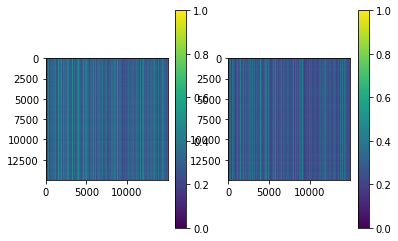

In [43]:
pl.figure()
pl.subplot(121)
pl.imshow(C1)
pl.colorbar()
pl.subplot(122)
pl.imshow(C2)
pl.colorbar()
pl.show()

In [20]:
p = ot.unif(S.shape[0])
q = ot.unif(T.shape[0])

t0 = time.time()
gw0, log0 = ot.gromov.gromov_wasserstein(
    C1, C2, p, q, 'square_loss', verbose=True, log=True)
print('duration GW: ', time.time()-t0)

t0 = time.time()
gw, log = ot.gromov.entropic_gromov_wasserstein(
    C1, C2, p, q, 'square_loss', epsilon=5e-4, log=True, verbose=True)
print('duration GW Entropic: ', time.time()-t0)

print('Gromov-Wasserstein distances: ' + str(log0['gw_dist']))
print('Entropic Gromov-Wasserstein distances: ' + str(log['gw_dist']))


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.910902e-02|0.000000e+00|0.000000e+00


RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/home/nkouagou/.conda/envs/unikge/lib/python3.8/site-packages/ot/lp/__init__.py:343: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


    1|7.261820e-03|3.008502e+00|2.184720e-02


RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher


    2|6.489868e-03|1.189473e-01|7.719521e-04


RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher


    3|6.489868e-03|0.000000e+00|0.000000e+00


/home/nkouagou/.conda/envs/unikge/lib/python3.8/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


It.  |Err         
-------------------
    0|2.302963e-04|
   10|4.573826e-10|
Gromov-Wasserstein distances: 0.0064898681170607615
Entropic Gromov-Wasserstein distances: 0.0033414554578393638


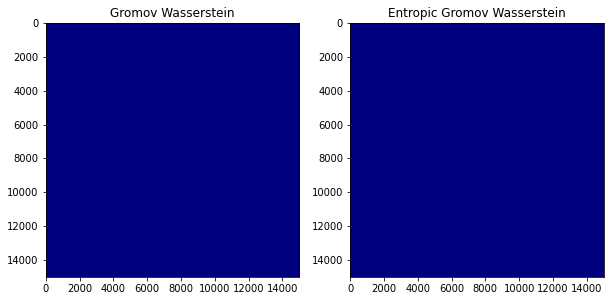

In [21]:
pl.figure(1, (10, 5))

pl.subplot(1, 2, 1)
pl.imshow(gw0, cmap='jet')
pl.title('Gromov Wasserstein')

pl.subplot(1, 2, 2)
pl.imshow(gw, cmap='jet')
pl.title('Entropic Gromov Wasserstein')

pl.show()

In [60]:
gw

array([[3.18181729e-018, 1.80440425e-010, 7.15428410e-018, ...,
        1.42651700e-014, 1.64594837e-048, 5.42291450e-049],
       [8.19848124e-009, 1.44219386e-013, 4.28895406e-059, ...,
        3.79729392e-010, 1.95338914e-013, 1.31644237e-013],
       [1.01670689e-016, 7.43681857e-028, 1.02339864e-092, ...,
        1.41382301e-020, 2.96571808e-008, 2.84432189e-008],
       ...,
       [3.44048080e-032, 5.01695205e-019, 6.94403901e-010, ...,
        2.28144908e-026, 1.52943336e-073, 3.61212403e-074],
       [3.71697799e-034, 5.34325133e-052, 2.91868216e-137, ...,
        1.14765672e-040, 9.63404245e-012, 1.26420830e-011],
       [4.19562636e-013, 3.73411235e-022, 1.08861833e-080, ...,
        3.89755927e-016, 6.02417909e-009, 5.19409225e-009]])

In [79]:
def evaluate_gw(gw, hits=[1, 5, 10]):
    def hits_k(ranks, k):
        return (ranks <= k-1).sum()/len(ranks)
    
    ids = np.arange(S.shape[0])
    ranks_ = gw.argsort(1)
    locs = np.where(ranks_ == ids.reshape(-1,1))[1]
    ranks = S.shape[0]-locs
    
    result = []
    for k in tqdm(hits):
        result.append(f"Hits@{k}: "+str(hits_k(ranks, k)))
    print(', '.join(result))

In [80]:
evaluate_gw(gw)

100%|██████████| 3/3 [00:00<00:00, 2646.81it/s]

Hits@1: 0.0, Hits@5: 0.0014, Hits@10: 0.0029333333333333334


In [81]:
evaluate_gw(gw.T)

100%|██████████| 3/3 [00:00<00:00, 10172.12it/s]

Hits@1: 0.0, Hits@5: 0.0012, Hits@10: 0.0026666666666666666


In [83]:
evaluate_gw(gw0)

100%|██████████| 3/3 [00:00<00:00, 8618.43it/s]

Hits@1: 0.0, Hits@5: 0.0002666666666666667, Hits@10: 0.0006


In [85]:
evaluate_gw(gw0.T)

100%|██████████| 3/3 [00:00<00:00, 5655.24it/s]

Hits@1: 0.0, Hits@5: 0.00013333333333333334, Hits@10: 0.0005333333333333334


In [14]:
import torch, pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
import time, gc
from sklearn.neighbors import NearestNeighbors
import random
from tqdm import tqdm
gc.enable()
random.seed(42)

In [15]:
def get_source_and_target_matrices(alignment_dict, entity2vec1, entity2vec2, given_test_set=None, emb_dim=200, test_size=0.2, scale=True, shift=True):
    """This function takes the dictionary of aligned entities between two KGs and their corresponding embeddings (as entity to vector dictionaries)
    and returns S, T, S_eval, T_eval, and R defined as follows:
    
    -- S: Normalized and scaled large subset of the source embeddings, i.e. the matrix of aligned entity embeddings in the first knowledge graph
    
    -- T: Normalized and scaled large subset of the matrix of aligned entity embeddings in the second knowledge graph
    
    -- S_eval and T_eval are portions of S and T sampled for evaluation if test_size > 0
    
    -- R: The rotation matrix that most closely maps S to T, i.e. ||A@S-T|| is minimized
    
    The mean and standard deviation of S, T are also returned
    """
    t0 = time.time()
    if test_size > 0:
        if given_test_set is None:
            train_ents, eval_ents = train_test_split(list(alignment_dict.keys()), test_size=test_size, random_state=42)
        else:
            eval_ents = given_test_set
            train_ents = list(set(alignment_dict.keys())-set(eval_ents))
    else:
        train_ents = alignment_dict.keys()
    
    S = np.empty((len(train_ents), emb_dim))
    T = np.empty((len(train_ents), emb_dim))
    if test_size > 0:
        S_eval = np.empty((len(eval_ents), emb_dim))
        T_eval = np.empty((len(eval_ents), emb_dim))

    for i, key in tqdm(enumerate(train_ents), total=len(train_ents), desc='Computing S and T'):
        S[i] = entity2vec1[key] if isinstance(entity2vec1, dict) else entity2vec1.loc[key].values
        T[i] = entity2vec2[alignment_dict[key]] if isinstance(entity2vec2, dict) else entity2vec2.loc[alignment_dict[key]].values
        
    if test_size > 0:
        for i, key in tqdm(enumerate(eval_ents), total=len(eval_ents), desc='Computing S_eval and T_eval'):
            S_eval[i] = entity2vec1[key] if isinstance(entity2vec1, dict) else entity2vec1.loc[key].values
            T_eval[i] = entity2vec2[alignment_dict[key]] if isinstance(entity2vec2, dict) else entity2vec2.loc[alignment_dict[key]].values
        
    print('\nNow computing R...')
    # Center and scale data
    mean_S = S.mean(axis=0)
    mean_T = T.mean(axis=0)
    scale_S = np.sqrt(((S-mean_S)**2).sum()/S.shape[0]) # scale, see https://en.wikipedia.org/wiki/Procrustes_analysis
    scale_T = np.sqrt(((T-mean_T)**2).sum()/T.shape[0])
    print('Scale S: ', scale_S)
    
    if shift and scale:
        R, loss = orthogonal_procrustes((S-mean_S)/scale_S, (T-mean_T)/scale_T, check_finite=True)
        print('\nCompleted after '+str(time.time()-t0)+' seconds')
    elif shift:
        R, loss = orthogonal_procrustes((S-mean_S), (T-mean_T), check_finite=True)
        print('\nCompleted after '+str(time.time()-t0)+' seconds')
    elif scale:
        R, loss = orthogonal_procrustes(S/scale_S, T/scale_T, check_finite=True)
        print('\nCompleted after '+str(time.time()-t0)+' seconds')
    else:
        R, loss = orthogonal_procrustes(S, T, check_finite=True)
        print('\nCompleted after '+str(time.time()-t0)+' seconds')
        
    print('Alignment loss: ', loss)
    if test_size > 0:
        if shift and scale:
            return scale_S, scale_T, mean_S, mean_T, (S-mean_S)/scale_S, (T-mean_T)/scale_T, (S_eval-mean_S)/scale_S, (T_eval-mean_T)/scale_T, R
        elif shift:
            return scale_S, scale_T, mean_S, mean_T, S-mean_S, T-mean_T, S_eval-mean_S, T_eval-mean_T, R
        elif scale:
            return scale_S, scale_T, mean_S, mean_T, S/scale_S, T/scale_T, S_eval/scale_S, T_eval/scale_T, R
        else:
            return scale_S, scale_T, mean_S, mean_T, S, T, S_eval, T_eval, R
    else:
        if shift and scale:
            return scale_S, scale_T, mean_S, mean_T, (S-mean_S)/scale_S, (T-mean_T)/scale_T, R
        elif shift:
            return scale_S, scale_T, mean_S, mean_T, S-mean_S, T-mean_T, R
        elif scale:
            return scale_S, scale_T, mean_S, mean_T, S/scale_S, T/scale_T, R
        else:
            return scale_S, scale_T, mean_S, mean_T, S, T, R
        
    

In [16]:
def get_non_aligned_entity_embedding_matrices(alignment_dict, entity2vec1, entity2vec2, scale_S, scale_T, mean_S, mean_T, emb_dim=200):
    """
    Inputs the dictionary of aligned entities between two KGs and their corresponding embeddings, and returns the normalized embedding matrices of 
    
    non-aligned entities
    """
    A_neg_S = np.empty((len(entity2vec1)-len(alignment_dict), emb_dim))
    keys = sorted(set(entity2vec1.keys() if isinstance(entity2vec1, dict) else entity2vec1.index)-set(alignment_dict.keys()))
    for i, key in tqdm(enumerate(keys), total=A_neg_S.shape[0], desc='Computing A_neg_S...'):
        A_neg_S[i] = entity2vec1[key] if isinstance(entity2vec1, dict) else entity2vec1.loc[key].values
    
    B_neg_T = np.empty((len(entity2vec2)-len(alignment_dict), emb_dim))
    keys = sorted(set(entity2vec2.keys() if isinstance(entity2vec2, dict) else entity2vec2.index)-set(alignment_dict.values()))
    for i, key in tqdm(enumerate(keys), total=B_neg_T.shape[0], desc='Computing B_neg_T...'):
        B_neg_T[i] = entity2vec2[key] if isinstance(entity2vec2, dict) else entity2vec2.loc[key].values
        
    return (A_neg_S-mean_S)/scale_S, (B_neg_T-mean_T)/scale_T
    

In [17]:
def evaluate_alignment_knn(S_eval, T_eval, R, assume_known=False, hit_values = [1, 3, 10], rotate=True):
    """The function takes the evaluation sets, i.e. correct alignments that were left out, and returns the hits@ and MRR results w.r.t. correct alignments
    
    --assume_known. A boolean variable. When set to True, the alignment results are computed using the fact that the test links are known
    
    """
    print('#'*50)
    print('Evaluation started...')
    print('#'*50)
    model = NearestNeighbors(n_neighbors=S_eval.shape[0], n_jobs=-1)
    print('Fitting 1...')
    model.fit(T_eval)
    print('Predicting 1...')
    if assume_known:
        if rotate:
            preds = model.kneighbors((S_eval@R+T_eval)/2, n_neighbors=S_eval.shape[0], return_distance=False)
        else:
            preds = model.kneighbors((S_eval+T_eval)/2, n_neighbors=S_eval.shape[0], return_distance=False)
    else:
        if rotate:
            preds = model.kneighbors(S_eval@R, n_neighbors=S_eval.shape[0], return_distance=False)
        else:
            preds = model.kneighbors(S_eval, n_neighbors=S_eval.shape[0], return_distance=False)
    Hits1 = np.zeros(len(hit_values))
    MRR1 = 0.0
    for i in tqdm(range(S_eval.shape[0]), total=S_eval.shape[0]):
        pred_idx = (preds[i]==i).nonzero()[0][0] # if i in preds[i] else S_eval.shape[0]
        MRR1 += (1./(pred_idx+1))
        for j in range(len(Hits1)):
            if pred_idx < hit_values[j]:
                Hits1[j] += 1.0/S_eval.shape[0]
    MRR1 = MRR1/S_eval.shape[0]
    
    model = NearestNeighbors(n_neighbors=S_eval.shape[0], n_jobs=-1)
    print('\nFitting 2...')
    if assume_known:
        if rotate:
            model.fit((S_eval@R+T_eval)/2)
        else:
            model.fit((S_eval+T_eval)/2)
    else:
        if rotate:
            model.fit(S_eval@R)
        else:
            model.fit(S_eval)
    print('Predicting 2...')
    preds = model.kneighbors(T_eval, n_neighbors=S_eval.shape[0], return_distance=False)
    Hits2 = np.zeros(len(hit_values))
    MRR2 = 0.0
    for i in tqdm(range(S_eval.shape[0]), total=S_eval.shape[0]):
        pred_idx = (preds[i]==i).nonzero()[0][0] # if i in preds[i] else S_eval.shape[0]
        MRR2 += (1./(pred_idx+1))
        for j in range(len(Hits2)):
            if pred_idx < hit_values[j]:
                Hits2[j] += 1.0/S_eval.shape[0]
    MRR2 = MRR2/S_eval.shape[0]
    
    Hits = (Hits1+Hits2)/2
    MRR = (MRR1+MRR2)/2
    print()
    print(', '.join([f'Hits@{hit_values[it]}: {Hits[it]}' for it in range(len(Hits))]+[f'MRR: {MRR}']))

## Dbpedia 15K V1

In [9]:
EnFr_shallom_embs_v1 = pd.read_csv('Shallom_EnFr_15K_V1/Shallom_entity_embeddings.csv')

Fr_shallom_embs_v1 = EnFr_shallom_embs_v1[EnFr_shallom_embs_v1['Unnamed: 0'].apply(lambda x: 'fr.dbpedia.org' in x)]

En_shallom_embs_v1 = EnFr_shallom_embs_v1.iloc[np.setdiff1d(np.arange(EnFr_shallom_embs_v1.shape[0]),\
                                                            np.array(Fr_shallom_embs_v1.index))].set_index('Unnamed: 0')

Fr_shallom_embs_v1 = Fr_shallom_embs_v1.set_index('Unnamed: 0')

En_shallom_embs_v1.head(3)

In [10]:
with open('OpenEA_dataset_v1.1/EN_FR_15K_V1/ent_links') as file:
    en_to_fr_ents_v1 = file.read().strip().split('\n')
en_to_fr_ents_v1 = dict([line.split('\t') for line in en_to_fr_ents_v1])

In [11]:
with open('OpenEA_dataset_v1.1/EN_FR_15K_V1/721_5fold/1/test_links') as file:
    test_set = file.read().strip().split('\n')
test_set = [line.split('\t')[0] for line in test_set]

In [12]:
len(test_set)

10500

In [26]:
_, _, _, _, _, _, S_eval, T_eval, R = get_source_and_target_matrices(en_to_fr_ents_v1,\
                                                En_shallom_embs_v1, Fr_shallom_embs_v1, given_test_set=None, emb_dim=300, test_size=0.2)

Computing S_eval and T_eval: 100%|██████████| 3000/3000 [00:00<00:00, 5781.30it/s]



Now computing R...
Scale S:  7.253442024613707

Completed after 2.993539810180664 seconds
Alignment loss:  4167.341864520468


In [27]:
evaluate_alignment_knn(S_eval, T_eval, R, assume_known=False, hit_values=[1, 5, 10], rotate=True)

##################################################
Evaluation started...
##################################################
Fitting 1...
Predicting 1...


100%|██████████| 3000/3000 [00:00<00:00, 87639.38it/s]



Fitting 2...
Predicting 2...


100%|██████████| 3000/3000 [00:00<00:00, 89500.12it/s]


Hits@1: 0.039333333333333345, Hits@5: 0.10566666666666717, Hits@10: 0.14666666666666686, MRR: 0.07445325324156875


In [30]:
scale_S, scale_T, mean_S, mean_T, S, T, R = get_source_and_target_matrices(en_to_fr_ents_v1,\
                                                                                    En_shallom_embs_v1, Fr_shallom_embs_v1, emb_dim=300, test_size=0.0)

Computing S and T: 100%|██████████| 15000/15000 [00:03<00:00, 4429.51it/s]



Now computing R...
Scale S:  7.246380617560009

Completed after 0.17420744895935059 seconds
Alignment loss:  5129.786850424131


### Get non aligned entity embeddings

In [18]:
A_neg_S, B_neg_T = get_non_aligned_entity_embedding_matrices(en_to_fr_ents_v1, En_shallom_embs_v1, \
                                                             Fr_shallom_embs_v1, scale_S, scale_T, mean_S, mean_T, emb_dim=300)

Computing A_neg_S...: 0it [00:00, ?it/s]
Computing B_neg_T...: 0it [00:00, ?it/s]


In [19]:
# compute every s_i as (s_i@R+t_i)/2
S = (S@R + T)/2
del T
gc.collect()
Universal_Emb = np.concatenate([A_neg_S@R, B_neg_T, S], axis=0)

In [20]:
Universal_Emb.shape

(15000, 300)

In [21]:
np.save('Shallom_EnFr_15K_V1/Universal_Emb.npy', Universal_Emb)

In [12]:
list_merged_entities = sorted(set(En_shallom_embs_v1.index)-set(en_to_fr_ents_v1.keys())) +\
sorted(set(Fr_shallom_embs_v1.index)-set(en_to_fr_ents_v1.values())) + \
list(en_to_fr_ents_v1.keys())
print('Total: ', len(list_merged_entities))
with open('Shallom_EnFr_15K_V1/list_merged_entities_db_fr_en.txt', 'w') as file:
    file.write('\t'.join(list_merged_entities))
del list_merged_entities

Total:  15000


In [11]:
with open('Shallom_EnFr_15K_V1/english2french.json', 'w') as file:
    json.dump(en_to_fr_ents_v1, file, ensure_ascii=False)

In [12]:
with open('Shallom_EnFr_15K_V1/french2english.json', 'w') as file:
    json.dump({value:key for key,value in en_to_fr_ents_v1.items()}, file, ensure_ascii=False)

## Dbpedia 15K V2

In [26]:
EnFr_shallom_embs_v2 = pd.read_csv('Shallom_EnFr_15K_V2/Shallom_entity_embeddings.csv')

In [27]:
Fr_shallom_embs_v2 = EnFr_shallom_embs_v2[EnFr_shallom_embs_v2['Unnamed: 0'].apply(lambda x: 'fr.dbpedia.org' in x)]

In [28]:
En_shallom_embs_v2 = EnFr_shallom_embs_v2.iloc[np.setdiff1d(np.arange(EnFr_shallom_embs_v2.shape[0]),\
                                                            np.array(Fr_shallom_embs_v2.index))].set_index('Unnamed: 0')

In [29]:
Fr_shallom_embs_v2 = Fr_shallom_embs_v2.set_index('Unnamed: 0')

In [30]:
En_shallom_embs_v2.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
http://dbpedia.org/resource/High_Rhulain,-0.188881,0.315095,0.308269,-0.626206,-0.246237,-0.234675,0.194418,-0.466016,0.507792,-0.421602,...,-0.358771,-0.163102,0.117546,-0.575519,0.333001,-0.031201,0.354539,0.154133,-0.543737,-0.172065
http://dbpedia.org/resource/The_Ultimate_Death_Worship,-0.064648,0.240301,-0.364626,-0.270227,0.007151,0.033877,-0.013944,0.019905,0.075945,-0.135914,...,-0.278595,0.075917,0.188317,-0.253808,0.111861,0.188110,0.112244,0.218195,-0.120202,0.280531
http://dbpedia.org/resource/1932_Monaco_Grand_Prix,-0.832162,1.881694,0.928277,-0.659394,-0.277395,-2.025897,-0.496428,-0.328969,0.608205,-1.468092,...,-1.501762,-0.841657,-0.315155,-1.317987,1.216074,0.325797,-0.414880,-0.784873,-1.022442,-0.222932


In [31]:
with open('OpenEA_dataset_v1.1/EN_FR_15K_V2/ent_links') as file:
    en_to_fr_ents_v2 = file.read().strip().split('\n')
en_to_fr_ents_v2 = dict([line.split('\t') for line in en_to_fr_ents_v2])

In [32]:
with open('OpenEA_dataset_v1.1/EN_FR_15K_V2/721_5fold/1/test_links') as file:
    test_set = file.read().strip().split('\n')
test_set = [line.split('\t')[0] for line in test_set]

In [33]:
_, _, _, _, _, _, S_eval, T_eval, R = get_source_and_target_matrices(en_to_fr_ents_v2,\
                                                En_shallom_embs_v2, Fr_shallom_embs_v2, given_test_set=test_set, emb_dim=300, test_size=0.2, shift=False)

Computing S_eval and T_eval: 100%|██████████| 10500/10500 [00:01<00:00, 5736.05it/s]



Now computing R...
Scale S:  10.211858760175005

Completed after 2.82313871383667 seconds
Alignment loss:  1784.6856410177932


In [35]:
evaluate_alignment_knn(S_eval, T_eval, R, assume_known=True, hit_values=[1, 5, 10])

##################################################
Evaluation started...
##################################################
Fitting 1...
Predicting 1...


100%|██████████| 10500/10500 [00:00<00:00, 43531.35it/s]



Fitting 2...
Predicting 2...


100%|██████████| 10500/10500 [00:00<00:00, 43793.50it/s]


Hits@1: 0.8485238095239908, Hits@3: 0.89176190476211, Hits@5: 0.9055714285716415, Hits@10: 0.9234285714287943, MRR: 0.8751949951271463


In [13]:
scale_S, scale_T, mean_S, mean_T, S, T, R = get_source_and_target_matrices(en_to_fr_ents_v2,\
                                                                                    En_shallom_embs_v2, Fr_shallom_embs_v2, emb_dim=300, test_size=0.0)

Computing S and T: 100%|██████████| 15000/15000 [00:02<00:00, 5526.73it/s]



Now computing R...
Scale S:  10.233623721278317

Completed after 0.10644793510437012 seconds
Alignment loss:  4933.507408174066


In [14]:
A_neg_S, B_neg_T = get_non_aligned_entity_embedding_matrices(en_to_fr_ents_v2, En_shallom_embs_v2, \
                                                             Fr_shallom_embs_v2, scale_S, scale_T, mean_S, mean_T, emb_dim=300)

Computing A_neg_S...: 0it [00:00, ?it/s]
Computing B_neg_T...: 0it [00:00, ?it/s]


In [47]:
# compute every s_i as (s_i@R+t_i)/2
S = (S@R + T)/2
del T
gc.collect()
Universal_Emb = np.concatenate([A_neg_S@R, B_neg_T, S], axis=0)

In [48]:
Universal_Emb.shape

(15000, 300)

In [49]:
np.save('Shallom_EnFr_15K_V2/Universal_Emb.npy', Universal_Emb)

In [50]:
list_merged_entities = sorted(set(En_shallom_embs_v2.index)-set(en_to_fr_ents_v2.keys())) +\
sorted(set(Fr_shallom_embs_v2.index)-set(en_to_fr_ents_v2.values())) + \
list(en_to_fr_ents_v2.keys())
print('Total: ', len(list_merged_entities))
with open('Shallom_EnFr_15K_V2/list_merged_entities_db_fr_en.txt', 'w') as file:
    file.write('\t'.join(list_merged_entities))
del list_merged_entities

Total:  15000


In [20]:
with open('Shallom_EnFr_15K_V2/english2french.json', 'w') as file:
    json.dump(en_to_fr_ents_v2, file, ensure_ascii=False)

In [21]:
with open('Shallom_EnFr_15K_V2/french2english.json', 'w') as file:
    json.dump({value:key for key,value in en_to_fr_ents_v2.items()}, file, ensure_ascii=False)

## Fr-En Dbpedia 100K V1

In [18]:
EnFr_shallom_embs_v1 = pd.read_csv('Shallom_EnFr_100K_V1/Shallom_entity_embeddings.csv')

In [19]:
Fr_shallom_embs_v1 = EnFr_shallom_embs_v1[EnFr_shallom_embs_v1['Unnamed: 0'].apply(lambda x: 'fr.dbpedia.org' in x)]

In [20]:
En_shallom_embs_v1 = EnFr_shallom_embs_v1.iloc[np.setdiff1d(np.arange(EnFr_shallom_embs_v1.shape[0]),\
                                                            np.array(Fr_shallom_embs_v1.index))].set_index('Unnamed: 0')

In [21]:
Fr_shallom_embs_v1 = Fr_shallom_embs_v1.set_index('Unnamed: 0')

In [22]:
En_shallom_embs_v1.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
http://dbpedia.org/resource/Early_Edition,0.297347,-0.105210,0.133634,0.123629,0.246443,0.050322,0.330174,0.045672,-0.254961,0.101142,...,0.037443,-0.316077,-0.131114,-0.028953,-0.571384,0.473524,-0.302664,-0.136760,0.118570,0.621989
http://dbpedia.org/resource/Above_the_Law_(group),0.369008,-0.166957,0.071992,-0.633617,-0.897680,0.198830,0.373352,0.634033,-0.760533,-1.018539,...,-0.041860,-0.272072,-0.463082,-0.034017,0.413505,0.353298,-0.936489,0.449733,0.527858,-0.059133
http://dbpedia.org/resource/Belmont-Broye,-0.133468,0.032227,-0.218811,-0.056487,-0.049560,-0.050581,-0.064817,0.064291,-0.062564,-0.036485,...,0.138861,-0.049767,-0.013609,0.055437,0.038148,-0.015300,0.027329,-0.134478,-0.043584,-0.078838


In [23]:
with open('OpenEA_dataset_v1.1/EN_FR_100K_V1/ent_links') as file:
    en_to_fr_ents_v1 = file.read().strip().split('\n')
en_to_fr_ents_v1 = dict([line.split('\t') for line in en_to_fr_ents_v1])

In [24]:
with open('OpenEA_dataset_v1.1/EN_FR_100K_V1/721_5fold/1/test_links') as file:
    test_set = file.read().strip().split('\n')
test_set = [line.split('\t')[0] for line in test_set]

In [18]:
_, _, _, _, _, _, S_eval, T_eval, R = get_source_and_target_matrices(en_to_fr_ents_v1,\
                                                En_shallom_embs_v1, Fr_shallom_embs_v1, given_test_set=test_set, emb_dim=300, test_size=0.2, shift=False, scale=False)

Computing S_eval and T_eval: 100%|██████████| 70000/70000 [00:13<00:00, 5325.54it/s]



Now computing R...
Scale S:  4.01483484955182

Completed after 19.374187231063843 seconds
Alignment loss:  127937.09914407574


In [19]:
evaluate_alignment_knn(S_eval, T_eval, R, assume_known=True, hit_values=[1, 5, 10])

##################################################
Evaluation started...
##################################################
Fitting 1...
Predicting 1...


100%|██████████| 70000/70000 [00:06<00:00, 11152.15it/s]



Fitting 2...
Predicting 2...


100%|██████████| 70000/70000 [00:15<00:00, 4568.08it/s]


Hits@1: 0.6886714285714185, Hits@5: 0.7706571428573058, Hits@10: 0.7980071428573635, MRR: 0.7272646254621687


In [25]:
scale_S, scale_T, mean_S, mean_T, S, T, R = get_source_and_target_matrices(en_to_fr_ents_v1,\
                                                                                    En_shallom_embs_v1, Fr_shallom_embs_v1, emb_dim=300, test_size=0.0)

Computing S and T: 100%|██████████| 100000/100000 [00:19<00:00, 5215.93it/s]



Now computing R...
Scale S:  4.016705119503967

Completed after 21.821853399276733 seconds
Alignment loss:  26959.67998550171


In [26]:
A_neg_S, B_neg_T = get_non_aligned_entity_embedding_matrices(en_to_fr_ents_v1, En_shallom_embs_v1, \
                                                             Fr_shallom_embs_v1, scale_S, scale_T, mean_S, mean_T, emb_dim=300)

Computing A_neg_S...: 0it [00:00, ?it/s]
Computing B_neg_T...: 0it [00:00, ?it/s]


In [27]:
# compute every s_i as (s_i@R+t_i)/2
S = (S@R + T)/2
del T
gc.collect()
Universal_Emb = np.concatenate([A_neg_S@R, B_neg_T, S], axis=0)

In [28]:
Universal_Emb.shape

(100000, 300)

In [29]:
np.save('Shallom_EnFr_100K_V1/Universal_Emb.npy', Universal_Emb)

In [18]:
list_merged_entities = sorted(set(En_shallom_embs_v1.index)-set(en_to_fr_ents_v1.keys())) +\
sorted(set(Fr_shallom_embs_v1.index)-set(en_to_fr_ents_v1.values())) + \
list(en_to_fr_ents_v1.keys())
print('Total: ', len(list_merged_entities))
with open('Shallom_EnFr_100K_V1/list_merged_entities_db_fr_en.txt', 'w') as file:
    file.write('\t'.join(list_merged_entities))
del list_merged_entities

Total:  100000


In [29]:
with open('Shallom_EnFr_100K_V1/english2french.json', 'w') as file:
    json.dump(en_to_fr_ents_v1, file, ensure_ascii=False)

In [30]:
with open('Shallom_EnFr_100K_V1/french2english.json', 'w') as file:
    json.dump({value:key for key,value in en_to_fr_ents_v1.items()}, file, ensure_ascii=False)

## Fr-En Dbpedia 100K V2

In [20]:
EnFr_shallom_embs_v2 = pd.read_csv('Shallom_EnFr_100K_V2/Shallom_entity_embeddings.csv')

In [21]:
Fr_shallom_embs_v2 = EnFr_shallom_embs_v2[EnFr_shallom_embs_v2['Unnamed: 0'].apply(lambda x: 'fr.dbpedia.org' in x)]

In [22]:
En_shallom_embs_v2 = EnFr_shallom_embs_v2.iloc[np.setdiff1d(np.arange(EnFr_shallom_embs_v2.shape[0]),\
                                                            np.array(Fr_shallom_embs_v2.index))].set_index('Unnamed: 0')

In [23]:
Fr_shallom_embs_v2 = Fr_shallom_embs_v2.set_index('Unnamed: 0')

In [24]:
En_shallom_embs_v2.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
http://dbpedia.org/resource/Sailing_to_Philadelphia,-0.107208,-0.463760,0.234986,-0.300843,-0.297771,0.157350,0.063645,0.219653,-0.373847,-0.517257,...,0.067203,-0.013326,0.009563,0.097662,-0.050666,0.292337,-0.091069,0.141930,0.412293,0.111441
http://dbpedia.org/resource/Horde_(band),-0.031448,0.542308,0.141856,-0.131928,-0.129672,0.056684,0.103640,0.017796,-0.080704,-0.920316,...,0.044921,0.069479,0.162442,0.144002,-0.108662,-0.412152,0.096725,0.008034,-0.273330,-0.185328
http://dbpedia.org/resource/Nessbeal,0.199559,-0.110438,0.225365,-0.145648,0.400099,-0.134547,0.287914,0.045707,0.731766,0.462888,...,0.217795,-0.313416,-0.295566,-0.239344,0.248340,0.115179,-0.185138,0.092450,-0.689202,0.140009


In [25]:
with open('OpenEA_dataset_v1.1/EN_FR_100K_V2/ent_links') as file:
    en_to_fr_ents_v2 = file.read().strip().split('\n')
en_to_fr_ents_v2 = dict([line.split('\t') for line in en_to_fr_ents_v2])

In [26]:
with open('OpenEA_dataset_v1.1/EN_FR_100K_V2/721_5fold/1/test_links') as file:
    test_set = file.read().strip().split('\n')
test_set = [line.split('\t')[0] for line in test_set]

In [35]:
_, _, _, _, _, _, S_eval, T_eval, R = get_source_and_target_matrices(en_to_fr_ents_v2,\
                                                En_shallom_embs_v2, Fr_shallom_embs_v2, given_test_set=test_set, emb_dim=300, test_size=0.2, shift=False, scale=False)

Computing S_eval and T_eval: 100%|██████████| 70000/70000 [00:12<00:00, 5533.71it/s]



Now computing R...
Scale S:  6.116433867944566

Completed after 18.63508653640747 seconds
Alignment loss:  298776.82671862666


In [2]:
evaluate_alignment_knn(S_eval, T_eval, R, assume_known=True, hit_values=[1, 5, 10])

In [14]:
scale_S, scale_T, mean_S, mean_T, S, T, R = get_source_and_target_matrices(en_to_fr_ents_v2,\
                                                                                    En_shallom_embs_v2, Fr_shallom_embs_v2, emb_dim=300, test_size=0.0)

Computing S and T: 100%|██████████| 100000/100000 [00:19<00:00, 5137.75it/s]



Now computing R...
Scale S:  6.113047898546291

Completed after 0.695664644241333 seconds
Alignment loss:  28446.94522432553


In [15]:
A_neg_S, B_neg_T = get_non_aligned_entity_embedding_matrices(en_to_fr_ents_v2, En_shallom_embs_v2, \
                                                             Fr_shallom_embs_v2, scale_S, scale_T, mean_S, mean_T, emb_dim=300)

Computing A_neg_S...: 0it [00:00, ?it/s]
Computing B_neg_T...: 0it [00:00, ?it/s]


In [16]:
# compute every s_i as (s_i@R+t_i)/2
S = (S@R + T)/2
del T
gc.collect()
Universal_Emb = np.concatenate([A_neg_S@R, B_neg_T, S], axis=0)

In [17]:
np.save('Shallom_EnFr_100K_V2/Universal_Emb.npy', Universal_Emb)

In [18]:
list_merged_entities = sorted(set(En_shallom_embs_v2.index)-set(en_to_fr_ents_v2.keys())) +\
sorted(set(Fr_shallom_embs_v2.index)-set(en_to_fr_ents_v2.values())) + \
list(en_to_fr_ents_v2.keys())
print('Total: ', len(list_merged_entities))
with open('Shallom_EnFr_100K_V2/list_merged_entities_db_fr_en.txt', 'w') as file:
    file.write('\t'.join(list_merged_entities))
del list_merged_entities

Total:  100000


In [38]:
with open('Shallom_EnFr_100K_V2/english2french.json', 'w') as file:
    json.dump(en_to_fr_ents_v2, file, ensure_ascii=False)

## Deutsch and English DBpedia

In [1]:
import torch, pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
import time, gc
from sklearn.neighbors import NearestNeighbors
import random
from tqdm import tqdm
gc.enable()
random.seed(42)

In [2]:
def get_source_and_target_matrices(alignment_dict, entity2vec1, entity2vec2, given_test_set=None, emb_dim=200, test_size=0.2, scale=True, shift=True):
    """This function takes the dictionary of aligned entities between two KGs and their corresponding embeddings (as entity to vector dictionaries)
    and returns S, T, S_eval, T_eval, and R defined as follows:
    
    -- S: Normalized and scaled large subset of the source embeddings, i.e. the matrix of aligned entity embeddings in the first knowledge graph
    
    -- T: Normalized and scaled large subset of the matrix of aligned entity embeddings in the second knowledge graph
    
    -- S_eval and T_eval are portions of S and T sampled for evaluation if test_size > 0
    
    -- R: The rotation matrix that most closely maps S to T, i.e. ||A@S-T|| is minimized
    
    The mean and standard deviation of S, T are also returned
    """
    t0 = time.time()
    if test_size > 0:
        if given_test_set is None:
            train_ents, eval_ents = train_test_split(list(alignment_dict.keys()), test_size=test_size, random_state=42)
        else:
            eval_ents = given_test_set
            train_ents = list(set(alignment_dict.keys())-set(eval_ents))
    else:
        train_ents = alignment_dict.keys()
    
    S = np.empty((len(train_ents), emb_dim))
    T = np.empty((len(train_ents), emb_dim))
    if test_size > 0:
        S_eval = np.empty((len(eval_ents), emb_dim))
        T_eval = np.empty((len(eval_ents), emb_dim))

    for i, key in tqdm(enumerate(train_ents), total=len(train_ents), desc='Computing S and T'):
        S[i] = entity2vec1[key] if isinstance(entity2vec1, dict) else entity2vec1.loc[key].values
        T[i] = entity2vec2[alignment_dict[key]] if isinstance(entity2vec2, dict) else entity2vec2.loc[alignment_dict[key]].values
        
    if test_size > 0:
        for i, key in tqdm(enumerate(eval_ents), total=len(eval_ents), desc='Computing S_eval and T_eval'):
            S_eval[i] = entity2vec1[key] if isinstance(entity2vec1, dict) else entity2vec1.loc[key].values
            T_eval[i] = entity2vec2[alignment_dict[key]] if isinstance(entity2vec2, dict) else entity2vec2.loc[alignment_dict[key]].values
        
    print('\nNow computing R...')
    # Center and scale data
    mean_S = S.mean(axis=0)
    mean_T = T.mean(axis=0)
    scale_S = np.sqrt(((S-mean_S)**2).sum()/S.shape[0]) # scale, see https://en.wikipedia.org/wiki/Procrustes_analysis
    scale_T = np.sqrt(((T-mean_T)**2).sum()/T.shape[0])
    print('Scale S: ', scale_S)
    
    if shift and scale:
        R, loss = orthogonal_procrustes((S-mean_S)/scale_S, (T-mean_T)/scale_T, check_finite=True)
        print('\nCompleted after '+str(time.time()-t0)+' seconds')
    elif shift:
        R, loss = orthogonal_procrustes((S-mean_S), (T-mean_T), check_finite=True)
        print('\nCompleted after '+str(time.time()-t0)+' seconds')
    elif scale:
        R, loss = orthogonal_procrustes(S/scale_S, T/scale_T, check_finite=True)
        print('\nCompleted after '+str(time.time()-t0)+' seconds')
    else:
        R, loss = orthogonal_procrustes(S, T, check_finite=True)
        print('\nCompleted after '+str(time.time()-t0)+' seconds')
        
    print('Alignment loss: ', loss)
    if test_size > 0:
        if shift and scale:
            return scale_S, scale_T, mean_S, mean_T, (S-mean_S)/scale_S, (T-mean_T)/scale_T, (S_eval-mean_S)/scale_S, (T_eval-mean_T)/scale_T, R
        elif shift:
            return scale_S, scale_T, mean_S, mean_T, S-mean_S, T-mean_T, S_eval-mean_S, T_eval-mean_T, R
        elif scale:
            return scale_S, scale_T, mean_S, mean_T, S/scale_S, T/scale_T, S_eval/scale_S, T_eval/scale_T, R
        else:
            return scale_S, scale_T, mean_S, mean_T, S, T, S_eval, T_eval, R
    else:
        if shift and scale:
            return scale_S, scale_T, mean_S, mean_T, (S-mean_S)/scale_S, (T-mean_T)/scale_T, R
        elif shift:
            return scale_S, scale_T, mean_S, mean_T, S-mean_S, T-mean_T, R
        elif scale:
            return scale_S, scale_T, mean_S, mean_T, S/scale_S, T/scale_T, R
        else:
            return scale_S, scale_T, mean_S, mean_T, S, T, R
        

In [3]:
def get_non_aligned_entity_embedding_matrices(alignment_dict, entity2vec1, entity2vec2, scale_S, scale_T, mean_S, mean_T, emb_dim=200):
    """
    Inputs the dictionary of aligned entities between two KGs and their corresponding embeddings, and returns the normalized embedding matrices of 
    
    non-aligned entities
    """
    A_neg_S = np.empty((len(entity2vec1)-len(alignment_dict), emb_dim))
    keys = sorted(set(entity2vec1.keys() if isinstance(entity2vec1, dict) else entity2vec1.index)-set(alignment_dict.keys()))
    for i, key in tqdm(enumerate(keys), total=A_neg_S.shape[0], desc='Computing A_neg_S...'):
        A_neg_S[i] = entity2vec1[key] if isinstance(entity2vec1, dict) else entity2vec1.loc[key].values
    
    B_neg_T = np.empty((len(entity2vec2)-len(alignment_dict), emb_dim))
    keys = sorted(set(entity2vec2.keys() if isinstance(entity2vec2, dict) else entity2vec2.index)-set(alignment_dict.values()))
    for i, key in tqdm(enumerate(keys), total=B_neg_T.shape[0], desc='Computing B_neg_T...'):
        B_neg_T[i] = entity2vec2[key] if isinstance(entity2vec2, dict) else entity2vec2.loc[key].values
        
    return (A_neg_S-mean_S)/scale_S, (B_neg_T-mean_T)/scale_T
    

In [4]:
def evaluate_alignment_knn(S_eval, T_eval, R, assume_known=False, hit_values = [1, 3, 10], rotate=True):
    """The function takes the evaluation sets, i.e. correct alignments that were left out, and returns the hits@ and MRR results w.r.t. correct alignments
    
    --assume_known. A boolean variable. When set to True, the alignment results are computed using the fact that the test links are known
    
    """
    print('#'*50)
    print('Evaluation started...')
    print('#'*50)
    model = NearestNeighbors(n_neighbors=S_eval.shape[0], n_jobs=-1)
    print('Fitting 1...')
    model.fit(T_eval)
    print('Predicting 1...')
    if assume_known:
        if rotate:
            preds = model.kneighbors((S_eval@R+T_eval)/2, n_neighbors=S_eval.shape[0], return_distance=False)
        else:
            preds = model.kneighbors((S_eval+T_eval)/2, n_neighbors=S_eval.shape[0], return_distance=False)
    else:
        if rotate:
            preds = model.kneighbors(S_eval@R, n_neighbors=S_eval.shape[0], return_distance=False)
        else:
            preds = model.kneighbors(S_eval, n_neighbors=S_eval.shape[0], return_distance=False)
    Hits1 = np.zeros(len(hit_values))
    MRR1 = 0.0
    for i in tqdm(range(S_eval.shape[0]), total=S_eval.shape[0]):
        pred_idx = (preds[i]==i).nonzero()[0][0] # if i in preds[i] else S_eval.shape[0]
        MRR1 += (1./(pred_idx+1))
        for j in range(len(Hits1)):
            if pred_idx < hit_values[j]:
                Hits1[j] += 1.0/S_eval.shape[0]
    MRR1 = MRR1/S_eval.shape[0]
    
    model = NearestNeighbors(n_neighbors=S_eval.shape[0], n_jobs=-1)
    print('\nFitting 2...')
    if assume_known:
        if rotate:
            model.fit((S_eval@R+T_eval)/2)
        else:
            model.fit((S_eval+T_eval)/2)
    else:
        if rotate:
            model.fit(S_eval@R)
        else:
            model.fit(S_eval)
    print('Predicting 2...')
    preds = model.kneighbors(T_eval, n_neighbors=S_eval.shape[0], return_distance=False)
    Hits2 = np.zeros(len(hit_values))
    MRR2 = 0.0
    for i in tqdm(range(S_eval.shape[0]), total=S_eval.shape[0]):
        pred_idx = (preds[i]==i).nonzero()[0][0] # if i in preds[i] else S_eval.shape[0]
        MRR2 += (1./(pred_idx+1))
        for j in range(len(Hits2)):
            if pred_idx < hit_values[j]:
                Hits2[j] += 1.0/S_eval.shape[0]
    MRR2 = MRR2/S_eval.shape[0]
    
    Hits = (Hits1+Hits2)/2
    MRR = (MRR1+MRR2)/2
    print()
    print(', '.join([f'Hits@{hit_values[it]}: {Hits[it]}' for it in range(len(Hits))]+[f'MRR: {MRR}']))

In [6]:
def export_to_csv(path):
    import torch
    import dask.dataframe as dd
    entity_embeddings=torch.load(f'{path}/Shallom_entity_embeddings.pt').detach().numpy()
    entity_to_idx = dd.read_parquet(f'{path}/entity_to_idx.gzip').compute()
    df = dd.from_array(entity_embeddings).compute()
    df=df.set_index(entity_to_idx.index)
    df.head()
    df.to_csv(f'{path}/Shallom_entity_embeddings.csv')

In [7]:
for path in ["Experiments/EN_DE_15K_V1", "Experiments/EN_DE_15K_V2", "Experiments/EN_DE_100K_V1", "Experiments/EN_DE_100K_V2"]:
    export_to_csv(path)

### 15k v1

In [8]:
EnDe_shallom_embs = pd.read_csv('Experiments/EN_DE_15K_V1/Shallom_entity_embeddings.csv')

De_shallom_embs = EnDe_shallom_embs[EnDe_shallom_embs['Unnamed: 0'].apply(lambda x: 'de.dbpedia.org' in x)]

En_shallom_embs = EnDe_shallom_embs.iloc[np.setdiff1d(np.arange(EnDe_shallom_embs.shape[0]),\
                                                            np.array(De_shallom_embs.index))].set_index('Unnamed: 0')

De_shallom_embs = De_shallom_embs.set_index('Unnamed: 0')

with open('OpenEA_dataset_v1.1/EN_DE_15K_V1/ent_links') as file:
    en_to_de_ents = file.read().strip().split('\n')
en_to_de_ents = dict([line.split('\t') for line in en_to_de_ents])

with open('OpenEA_dataset_v1.1/EN_DE_15K_V1/721_5fold/1/test_links') as file:
    test_set = file.read().strip().split('\n')
test_set = [line.split('\t')[0] for line in test_set]


In [9]:
De_shallom_embs.shape

(15000, 300)

In [44]:
_, _, _, _, _, _, S_eval, T_eval, R = get_source_and_target_matrices(en_to_de_ents,\
                                                En_shallom_embs, De_shallom_embs, given_test_set=test_set, emb_dim=300, test_size=0.2, scale=False, shift=False)

evaluate_alignment_knn(S_eval, T_eval, R, assume_known=True, hit_values=[1, 5, 10])

Computing S_eval and T_eval: 100%|██████████| 10500/10500 [00:01<00:00, 5479.53it/s]



Now computing R...
Scale S:  0.05050015345675206

Completed after 3.037355422973633 seconds
Alignment loss:  7.813596754606659
##################################################
Evaluation started...
##################################################
Fitting 1...
Predicting 1...


100%|██████████| 10500/10500 [00:00<00:00, 45059.44it/s]



Fitting 2...
Predicting 2...


100%|██████████| 10500/10500 [00:00<00:00, 44068.35it/s]


Hits@1: 0.41747619047618023, Hits@5: 0.5862380952381306, Hits@10: 0.6490952380953084, MRR: 0.49776320692690734


## 15k v2

In [125]:
EnDe_shallom_embs = pd.read_csv('Experiments/EN_DE_15K_V2/Shallom_entity_embeddings.csv')

De_shallom_embs = EnDe_shallom_embs[EnDe_shallom_embs['Unnamed: 0'].apply(lambda x: 'de.dbpedia.org' in x)]

En_shallom_embs = EnDe_shallom_embs.iloc[np.setdiff1d(np.arange(EnDe_shallom_embs.shape[0]),\
                                                            np.array(De_shallom_embs.index))].set_index('Unnamed: 0')

De_shallom_embs = De_shallom_embs.set_index('Unnamed: 0')

with open('OpenEA_dataset_v1.1/EN_DE_15K_V2/ent_links') as file:
    en_to_de_ents = file.read().strip().split('\n')
en_to_de_ents = dict([line.split('\t') for line in en_to_de_ents])

with open('OpenEA_dataset_v1.1/EN_DE_15K_V2/721_5fold/1/test_links') as file:
    test_set = file.read().strip().split('\n')
test_set = [line.split('\t')[0] for line in test_set]


In [128]:
_, _, _, _, _, _, S_eval, T_eval, R = get_source_and_target_matrices(en_to_de_ents,\
                                                En_shallom_embs, De_shallom_embs, given_test_set=test_set, emb_dim=300, test_size=0.2, scale=False, shift=False)

evaluate_alignment_knn(S_eval, T_eval, R, assume_known=True, hit_values=[1, 5, 10])

Computing S_eval and T_eval: 100%|██████████| 10500/10500 [00:01<00:00, 5406.62it/s]



Now computing R...
Scale S:  0.04797353058639573

Completed after 0.21141839027404785 seconds
Alignment loss:  7.12450207466435
##################################################
Evaluation started...
##################################################
Fitting 1...
Predicting 1...


100%|██████████| 10500/10500 [00:00<00:00, 46697.61it/s]



Fitting 2...
Predicting 2...


100%|██████████| 10500/10500 [00:00<00:00, 45976.64it/s]


Hits@1: 0.46542857142857996, Hits@5: 0.6234285714286275, Hits@10: 0.6857619047619955, MRR: 0.5412170755634034


### 100k v1

In [8]:
EnDe_shallom_embs = pd.read_csv('Experiments/EN_DE_100K_V1/Shallom_entity_embeddings.csv')

De_shallom_embs = EnDe_shallom_embs[EnDe_shallom_embs['Unnamed: 0'].apply(lambda x: 'de.dbpedia.org' in x)]

En_shallom_embs = EnDe_shallom_embs.iloc[np.setdiff1d(np.arange(EnDe_shallom_embs.shape[0]),\
                                                            np.array(De_shallom_embs.index))].set_index('Unnamed: 0')

De_shallom_embs = De_shallom_embs.set_index('Unnamed: 0')

with open('OpenEA_dataset_v1.1/EN_DE_100K_V1/ent_links') as file:
    en_to_de_ents = file.read().strip().split('\n')
en_to_de_ents = dict([line.split('\t') for line in en_to_de_ents])

with open('OpenEA_dataset_v1.1/EN_DE_100K_V1/721_5fold/1/test_links') as file:
    test_set = file.read().strip().split('\n')
test_set = [line.split('\t')[0] for line in test_set]


In [10]:
_, _, _, _, _, _, S_eval, T_eval, R = get_source_and_target_matrices(en_to_de_ents,\
                                                En_shallom_embs, De_shallom_embs, given_test_set=test_set, emb_dim=300, test_size=0.2, shift=False, scale=False)

evaluate_alignment_knn(S_eval, T_eval, R, assume_known=True, hit_values=[1, 5, 10])

Computing S_eval and T_eval: 100%|██████████| 70000/70000 [00:12<00:00, 5598.68it/s]



Now computing R...
Scale S:  0.021902208641113658

Completed after 18.421804189682007 seconds
Alignment loss:  8.544725213632967
##################################################
Evaluation started...
##################################################
Fitting 1...
Predicting 1...


100%|██████████| 70000/70000 [00:06<00:00, 11287.51it/s]



Fitting 2...
Predicting 2...


100%|██████████| 70000/70000 [00:06<00:00, 10155.74it/s]


Hits@1: 0.2834999999999413, Hits@5: 0.4085714285711827, Hits@10: 0.46552857142828574, MRR: 0.3456914632419348


In [9]:
scale_S, scale_T, mean_S, mean_T, S, T, R = get_source_and_target_matrices(en_to_de_ents,\
                                                En_shallom_embs, De_shallom_embs, given_test_set=test_set, emb_dim=300, test_size=0.0)

Computing S and T: 100%|██████████| 100000/100000 [00:18<00:00, 5528.14it/s]



Now computing R...
Scale S:  0.021967541711728614

Completed after 19.402446746826172 seconds
Alignment loss:  62694.90656351184


In [10]:
# compute every s_i as (s_i@R+t_i)/2
S = (S@R + T)/2
del T
gc.collect()

0

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--es_index", nargs='+', type=str, default=["DBP_EN_FR_15K", "DBP_EN_FR_100K", "DBP_EN_DE_100K"], \
                    help="Preferred dataset name on Elastic Search")
parser.add_argument("--data_folder", nargs='+', type=str, default=["Shallom_EnFr_15K_V1/", "Shallom_EnFr_100K_V1/", "Experiments/EN_DE_100K_V1/"],\
                   help="Names of folders where universal embeddings are located")
parser.add_argument("--max_docs", type=int, default=10000, help="Batch size of documents to upload")
parser.add_argument("--password", type=str, default=None, help="Password to upload or delete data")

In [11]:
np.save('Experiments/EN_DE_100K_V1//Universal_Emb.npy', S)

In [12]:
with open('Experiments/EN_DE_100K_V1/list_merged_entities_db_en_de.txt', 'w') as file:
    file.write('\t'.join(en_to_de_ents))

In [13]:
with open('Experiments/EN_DE_100K_V1/english2german.json', 'w') as file:
    json.dump(en_to_de_ents, file, ensure_ascii=False)

### 100k v2

In [5]:
EnDe_shallom_embs = pd.read_csv('Experiments/EN_DE_100K_V2/Shallom_entity_embeddings.csv')

De_shallom_embs = EnDe_shallom_embs[EnDe_shallom_embs['Unnamed: 0'].apply(lambda x: 'de.dbpedia.org' in x)]

En_shallom_embs = EnDe_shallom_embs.iloc[np.setdiff1d(np.arange(EnDe_shallom_embs.shape[0]),\
                                                            np.array(De_shallom_embs.index))].set_index('Unnamed: 0')
De_shallom_embs = De_shallom_embs.set_index('Unnamed: 0')

with open('OpenEA_dataset_v1.1/EN_DE_100K_V2/ent_links') as file:
    en_to_de_ents = file.read().strip().split('\n')
en_to_de_ents = dict([line.split('\t') for line in en_to_de_ents])

with open('OpenEA_dataset_v1.1/EN_DE_100K_V2/721_5fold/1/test_links') as file:
    test_set = file.read().strip().split('\n')
test_set = [line.split('\t')[0] for line in test_set]


In [13]:
_, _, _, _, _, _, S_eval, T_eval, R = get_source_and_target_matrices(en_to_de_ents,\
                                                En_shallom_embs, De_shallom_embs, given_test_set=test_set, emb_dim=300, test_size=0.2, shift=False, scale=False)

evaluate_alignment_knn(S_eval, T_eval, R, assume_known=True, hit_values=[1, 5, 10])

Computing S_eval and T_eval: 100%|██████████| 70000/70000 [00:13<00:00, 5180.54it/s]



Now computing R...
Scale S:  0.02760568790057487

Completed after 19.92166757583618 seconds
Alignment loss:  14.747715207779663
##################################################
Evaluation started...
##################################################
Fitting 1...
Predicting 1...


100%|██████████| 70000/70000 [00:06<00:00, 11384.53it/s]



Fitting 2...
Predicting 2...


100%|██████████| 70000/70000 [00:12<00:00, 5568.78it/s] 


Hits@1: 0.49427142857128803, Hits@5: 0.6583214285713545, Hits@10: 0.7198214285714842, MRR: 0.5721232082416863


### Scalability

In [28]:
import matplotlib.pyplot as plt

In [29]:
time = [[4.3, 8.3, 12.9, 17.1], [329, 300.6], [350.8, 1084.5]]
MRR = [[0.47, 0.43, 0.29, 0.40], [0.35, 0.33], [0.04, 0.04]]
x_axis = ["50K", "100K", "150K", "200K"]

Text(0, 0.5, 'Training time')

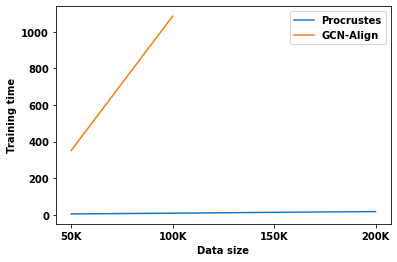

In [40]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.plot(x_axis, time[0])
#plt.plot(x_axis[:2], time[1])
plt.plot(x_axis[:2], time[2])
plt.legend(("Procrustes", "GCN-Align"))
plt.xlabel("Data size")
plt.ylabel("Training time")

In [ ]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.plot(x_axis, time[0])
#plt.plot(x_axis[:2], time[1])
plt.plot(x_axis[:2], time[2])
plt.legend(("Procrustes", "GCN-Align"))
plt.xlabel("Data size")
plt.ylabel("Training time")